In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch

/var/folders/14/l3lz9l417qx68dth25zm8r7m0000gn/T/ipykernel_10227/3964348248.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
yf.pdr_override() # <== that's all it takes :-)

# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'SPY'

# Define the time period for historical data
start_date = datetime(2020, 1, 1)
end_date = datetime(2022, 1, 1)

# download dataframe
data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)

# Display the first few rows
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,305.058380,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,302.748413,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,303.903442,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,303.048950,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,304.664062,68296000


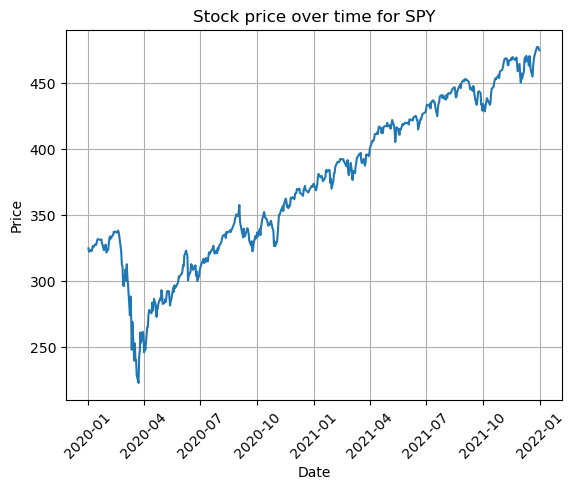

In [3]:
# plot the close prices

import matplotlib.pyplot as plt

plt.plot(data['Close'])
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
# rotate the x-axis dates
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Moving Average just to analyse the price

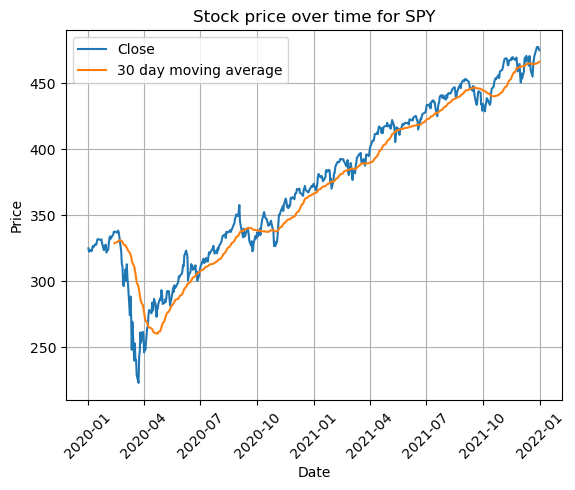

In [4]:
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()

plt.plot(data['Close'], label='Close')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()

## Implement DQNetwork

In [6]:
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

# Fetch stock data from Yahoo Finance
stock_symbol = 'AAPL' # The stock symbol for Apple here
start_date = datetime(2020, 1, 1) # Start date for the data
end_date = datetime(2021, 1, 1) # End date for the data
data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date) # Download the data

# Parameters
T = 20
sync_period=30
lr = 0.004
rb = 2000
es = 0.82
em = 0.013
ed = 0.9675
num_episodes=10
gamma=0.9
batch_size=128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


model = DQN(T+2, 1, device).to(device)
target_model = DQN(T+2, 1, device).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

replay_buffer = ReplayBuffer(rb)
env = SimplifiedStockTradingEnv(data, T=T)
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
agent.train(num_episodes, gamma, batch_size)


[*********************100%%**********************]  1 of 1 completed

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/juliengadonneix/Desktop/code/INF581/Project/RL4Trading/utils/epsilon_greedy.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32, device=self.model.device)
/Users/juliengadonneix/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Some informations about the environment

In [ ]:
# action space
print(f'Action space: {env.action_space.n}')
print('Labels for each action')
for label in env.action_labels :
    print(f'   * {label}: {env.action_labels[label]}')

Action space: 3
Labels for each action
   * 0: Buy
   * 1: Sell
   * 2: Hold


## DQN Training

In [ ]:
# Training loop
EPISODES = 50
for episode in range(1, EPISODES + 1):
    state = env.reset()
    print(f"Episode: {episode}, Close Price: {state[0]}, Balance: {env.balance}, Shares Held: {env.shares_held}")
    total_reward = 0
    done = False

    for t in itertools.count():
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        print(f"Episode: {episode}, Close Price: {state[0]}, Balance: {env.balance}, Shares Held: {env.shares_held}")

        total_reward += reward
        print(f"Episode: {episode}, Action: {action}, Total Reward: {reward}")

        if done:
            break
        

    print(f'Episode: {episode}, Total Reward: {total_reward}')

# Final account balance
print(f'Final account balance: {env.balance}')


Episode: 1, Close Price: 0.5493269455318507, Balance: 1, Shares Held: 0
0 253
Episode: 1, Close Price: 0.5439863694553632, Balance: 1.0, Shares Held: 0.0
Episode: 1, Action: 2, Total Reward: 0.0
1 253
Episode: 1, Close Price: 0.5483209862430896, Balance: 1.0, Shares Held: 0.0
Episode: 1, Action: 2, Total Reward: 0.0
2 253
Episode: 1, Close Price: 0.5457422074016456, Balance: 1.0, Shares Held: 0.0
Episode: 1, Action: 2, Total Reward: 0.0
3 253
Episode: 1, Close Price: 0.5545211738718275, Balance: 1.0, Shares Held: 0.0
Episode: 1, Action: 2, Total Reward: 0.0
4 253
Episode: 1, Close Price: 0.5662996549720946, Balance: 1.0, Shares Held: 0.0
Episode: 1, Action: 2, Total Reward: 0.0
5 253
Episode: 1, Close Price: 0.5675798906823711, Balance: 0.99, Shares Held: 0.00012918644630432067
Episode: 1, Action: 1, Total Reward: 2.2607036734623165e-05
6 253
Episode: 1, Close Price: 0.5797058778877165, Balance: 0.9801, Shares Held: 0.000256792548561469
Episode: 1, Action: 1, Total Reward: 0.0004256339